<a href="https://colab.research.google.com/github/luctiz/Grupo43-TP2/blob/master/TensorFlow_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# CARGO LOS SETS DE DATOS

In [0]:
mexico_housing_dataframe = pd.read_csv("https://metadata.fundacionsadosky.org.ar/media/navent/train.csv", sep=",")

In [0]:
test =  pd.read_csv("https://metadata.fundacionsadosky.org.ar/media/navent/test.csv", sep=",")
train = mexico_housing_dataframe
ejemplo = pd.read_csv("https://metadata.fundacionsadosky.org.ar/media/navent/ejemploRespuesta.csv", sep=",")

# UTILIZO LA MISMA LIMPIEZA QUE OTROS ANALISIS 

In [0]:
#A los nulls los relleno con el promedio de metroscubiertos de todas las publicaciones
train['metroscubiertos']=train['metroscubiertos'].fillna(round(train['metroscubiertos'].mean()))
test['metroscubiertos']=test['metroscubiertos'].fillna(round(test['metroscubiertos'].mean()))
#Luego convierto metroscubiertos a  np.int16
train['metroscubiertos']=train['metroscubiertos'].astype(np.int16)
test['metroscubiertos']=test['metroscubiertos'].astype(np.int16)

#A los nulls los relleno con el promedio de metrostotales de todas las publicaciones
train['metrostotales']=train['metrostotales'].fillna(round(train['metrostotales'].mean()))
test['metrostotales']=test['metrostotales'].fillna(round(test['metrostotales'].mean()))
#Luego convierto metrostotales a  np.int16
train['metrostotales']=train['metrostotales'].astype(np.int16)
test['metrostotales']=test['metrostotales'].astype(np.int16)

#El precio promedio de las publicaciones que no tienen datos de cant de habitaciones esta entre el precio
#promedio de las que tienen 2 y 3 habitaciones
#Entonces voy a asumir que tienen 3 habitaciones, ya que es el valor al cual el precio mas se les asemeja.
train['habitaciones']=train['habitaciones'].fillna(3)
test['habitaciones']=test['habitaciones'].fillna(3)
#Luego convierto a np.int8
train['habitaciones']=train['habitaciones'].astype(np.int8)
test['habitaciones']=test['habitaciones'].astype(np.int8)

#A los que no tienen datos de antiguedad los relleno con la antiguedad promedio (es 8)
train['antiguedad']=train['antiguedad'].fillna(round(train['antiguedad'].mean()))
test['antiguedad']=test['antiguedad'].fillna(round(train['antiguedad'].mean()))
#Luego convierto a np.uint8
train['antiguedad']=train['antiguedad'].astype(np.uint8)
test['antiguedad']=test['antiguedad'].astype(np.uint8)

#El precio promedio de los que tienen NULL en garage es parecido al de los que tienen 2.
#Relleno los nulls de esta columna con un 2.
train['garages']=train['garages'].fillna(2)
test['garages']=test['garages'].fillna(2)
#convierto a np.int8
train['garages']=train['garages'].astype(np.int8)
test['garages']=test['garages'].astype(np.int8)

#El precio promedio de los que tienen NULL en banos es mas parecido al de los que tienen 2.
#Relleno los nulls de esta columna con un 2.
train['banos']=train['banos'].fillna(2)
test['banos']=test['banos'].fillna(2)
#convierto a np.int8
train['banos']=train['banos'].astype(np.int8)
test['banos']=test['banos'].astype(np.int8)

train['gimnasio']=train['gimnasio'].astype(np.int8)
train['usosmultiples']=train['usosmultiples'].astype(np.int8)
train['piscina']=train['piscina'].astype(np.int8)
train['escuelascercanas']=train['escuelascercanas'].astype(np.int8)
train['centroscomercialescercanos']=train['centroscomercialescercanos'].astype(np.int8)
test['gimnasio']=test['gimnasio'].astype(np.int8)
test['usosmultiples']=test['usosmultiples'].astype(np.int8)
test['piscina']=test['piscina'].astype(np.int8)
test['escuelascercanas']=test['escuelascercanas'].astype(np.int8)
test['centroscomercialescercanos']=test['centroscomercialescercanos'].astype(np.int8)

#Creo categoria para los que no tienen categoria en provincia:
train['provincia']=train['provincia'].fillna('N/A')
test['provincia']=test['provincia'].fillna('N/A')
#Creo categoria para los que no tienen categoria en ciudad:
train['ciudad']=train['ciudad'].fillna('N/A')
test['ciudad']=test['ciudad'].fillna('N/A')
#Relleno los nulls en direccion con un - .
train['direccion']=train['direccion'].fillna('-')
test['direccion']=test['direccion'].fillna('-')
#Creo categoria para los que no tienen categoria en tipodepropiedad:
train['tipodepropiedad']=train['tipodepropiedad'].fillna('N/A')
test['tipodepropiedad']=test['tipodepropiedad'].fillna('N/A')

train['titulo']=train['titulo'].fillna(' ')
train['descripcion']=train['descripcion'].fillna(' ')
test['titulo']=test['titulo'].fillna(' ')
test['descripcion']=test['descripcion'].fillna(' ')

train['precio']=train['precio'].astype(np.int32)
train['id']=train['id'].astype(np.int32)
test['id']=test['id'].astype(np.int32)

train=train.fillna(0)
test=test.fillna(0)

In [0]:
mexico_housing_dataframe = train

# MODELO DE ENTRENAMIENTO CON UN FEATURE - TENSOR FLOW

In [0]:
#Realizo una permutacion para el análisis de las filas (Aleatorios)
mexico_housing_dataframe = mexico_housing_dataframe.reindex(np.random.permutation(mexico_housing_dataframe.index))
mexico_housing_dataframe["precio"] /= 1000.0
mexico_housing_dataframe

FUNCION DE ENTRADA

In [0]:
def my_input_fn(features, targets, batch_size, shuffle=True, num_epochs=None):
    
    # Conversion de  pandas data  a dict de np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    # Construyo un dataset, y configuro batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # Peligro: 2GB es el limite
    ds = ds.batch(batch_size).repeat(num_epochs)
    # Shuffle los dato en caso de especificarlo
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    # Retorno el proximo lote de datos.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

FUNCION DE ENTRENAMIENTO

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="habitaciones"):
    #SE EJECUTAN 10 PERIODOS DE PRUEBAS CON RELACION A LOS HYPERPARAMETROS QUE SE PASAN
    periods = 10
    steps_per_period = steps / periods
    # Definicion de los features de entrada: habitaciones
    my_feature = mexico_housing_dataframe[["habitaciones"]]
    # Configure una columna numerica para habitaciones
    feature_columns = [tf.feature_column.numeric_column("habitaciones")]

    # Definicion del Label ( targets )
    targets = mexico_housing_dataframe["precio"]

    prediction_input_fn = lambda: my_input_fn(my_feature, targets,batch_size=1, num_epochs=1, shuffle=False)

    # Utilizacion de 'Gradient Descent' par la optimización del modelo /////PODRIA CAMBIARSE PERO ES UNA HERRAMIENTA DE TF
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate) #ESTE ARGUMENTO SE PASA (RANGO DE APRENDIZAJE)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

    # Configuracion de 'regresion lineal' para el modelo con nuestroa columnda de feature y optimizador.
    # Seteo rango de aprendizaje de 0.0000001 para el 'Gradient Descent'.

    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )

    # Visualizacion de aprendizaje por periodo.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Linea de aprendizaje por Periodo")
    plt.ylabel("precio")
    plt.xlabel("habitaciones")
    sample = mexico_housing_dataframe.sample(n=300)
    plt.scatter(sample["habitaciones"], sample["precio"])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  #ENTRENAMIENTO DEL MODELO=====================================================
    
    print("Entrenando Modelo...")
    print("RMSE (en Data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
      linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets, batch_size=1),
        steps=steps_per_period
        )
      # REALIZO PREDICCION
      # Llamo a  predict() en linear_regressor para hacer predicciones.
      predictions = linear_regressor.predict(input_fn=prediction_input_fn)
      # Formateo las predicciones como un NumPy array, para poder calcular metricas.
      predictions = np.array([item['predictions'][0] for item in predictions])
      # Computar perdida.
      root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
      root_mean_squared_errors.append(root_mean_squared_error)
      # Imprimir la perdida actual.
      print("  Periodo %02d : %0.2f" % (period, root_mean_squared_error))

      y_extents = np.array([0, sample["precio"].max()])
    
      weight = linear_regressor.get_variable_value('linear/linear_model/habitaciones/weights')[0]
      bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

      x_extents = (y_extents - bias) / weight
      x_extents = np.maximum(np.minimum(x_extents,
                                      sample["habitaciones"].max()),
                           sample["habitaciones"].min())
      y_extents = weight * x_extents + bias
      plt.plot(x_extents, y_extents, color=colors[period]) 
 
    print("Final de entrenamiento.")
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periodos')
    plt.title("Error cuadratico Medio vs. Periodos")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Resultado final  RMSE (sobre los datos): %0.2f" % root_mean_squared_error)

EJECUTO ENTRENAMIENTO Y ANALIZO ERROR 

In [0]:
#ACLARACION: SE UTILIZA COMO FEATURE EL NUMERO DE HABITACIONES
train_model(
    learning_rate=0.0001,  #AJUSTES DE HYPERPARAMETROS
    steps=500,
    batch_size=5
)

# MODELO PARA VARIOS FEATURES - TENSOR FLOW

In [0]:
#LUEGO DE LA LIMPIEZA DE DATOS
mexico_housing_dataframe = train

In [0]:
#PREPOCESAMIENTO DE DATOS

def preprocess_features(california_housing_dataframe):
  selected_features = california_housing_dataframe[
    ["antiguedad",
     "habitaciones",
     "garages",
     "banos",
     "metroscubiertos",
     "metrostotales",
     "lat",
     "lng"]]
  processed_features = selected_features.copy()
  # Creacion de un feature Sintetico.
  processed_features["extras"] = (
    mexico_housing_dataframe["gimnasio"] +
    mexico_housing_dataframe["usosmultiples"] +
    mexico_housing_dataframe["centroscomercialescercanos"] +
    mexico_housing_dataframe["escuelascercanas"] +
    mexico_housing_dataframe["piscina"] )
  return processed_features

def preprocess_targets(mexico_housing_dataframe):
  output_targets = pd.DataFrame()
  # Escalar a unidades de miles la moneda.
  output_targets["precio"] = (
    mexico_housing_dataframe["precio"] / 1000.0)
  return output_targets

CONJUNTO DE VALIDACION

In [0]:
training_examples = preprocess_features(mexico_housing_dataframe.head(168000))
training_targets = preprocess_targets(mexico_housing_dataframe.head(168000))
validation_examples = preprocess_features(mexico_housing_dataframe.tail(72000))
validation_targets = preprocess_targets(mexico_housing_dataframe.tail(72000))

FUNCIONES DE ENTRADAS

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convertir pandas a un listado de numpy .
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construyendo un dataset, y configurando batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # El limite es de 2GB
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Mezclar Datos, si se especifica.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return del proximo batch de datos.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

FUNCION PARA ENTRADA DE VARIOS FEATURES

In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

FUNCION DE ENTRENAMIENTO DEL MODELO

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  
  periods = 10
  steps_per_period = steps / periods
  
  # Regresion Lineal.=====GRADIENT DESCENT======================================
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Configuracion de Funciones de Entrada.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["precio"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["precio"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["precio"], 
      num_epochs=1, 
      shuffle=False)

  # Entrenamiento del Modelo==================================================== 
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Entrenando modelo comenzando por el primer Periodo
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Realizando Computos.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Validacion de Perdida.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Imprimir la Perdida actual .
    print("  Periodo %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Añadir las metricas de Perdida a la muestra.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Entrenamiento Finalizado.")

  # GRAFICANDO LAS METRICAS PARA CADA PERIODO===================================
  plt.ylabel("RMSE")
  plt.xlabel("Periodos")
  plt.title("Raiz del Error Cuadràtico Medio vs. Periodos")
  plt.tight_layout()
  plt.plot(training_rmse, label="Entrenando")
  plt.plot(validation_rmse, label="Validando")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 3315.71
  period 01 : 3313.98
  period 02 : 3312.25
  period 03 : 3310.53
  period 04 : 3308.80
  period 05 : 3307.08
  period 06 : 3305.36
  period 07 : 3303.63
  period 08 : 3301.90
  period 09 : 3300.18
Model training finished.


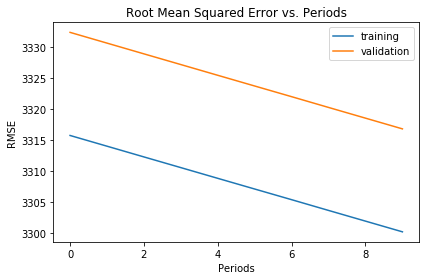

In [74]:
linear_regressor = train_model(
    learning_rate=0.0003,
    steps=1000,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)